In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt 
from numba import jit

## Running Max of Brownian Motion

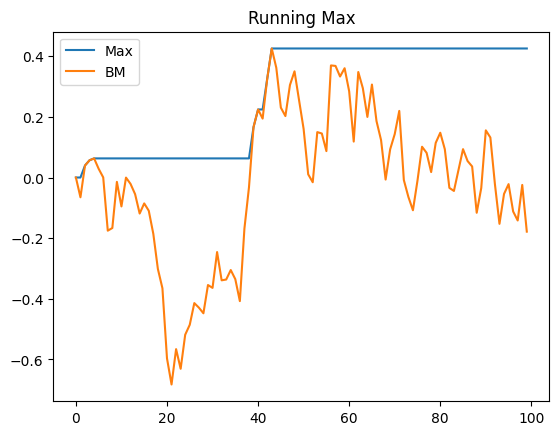

In [2]:
N = 100
rv = np.random.normal(0, 1, N)
dt = 1 / N

M = np.zeros(N)
W = np.zeros(N)

for i in range(1, N):
    
    W[i] = W[i - 1] + rv[i] * np.sqrt(dt)
    
    if rv[i] > 0:
        M[i] = np.max(W)
    else: 
        M[i] = M[i - 1]
        
plt.plot(M, label = "Max")
plt.plot(W, label = "BM")
plt.title("Running Max")
plt.legend(loc = 'best')
plt.show()

## What do you observe? 

#### The running max is strictly increasing, while the brownian motion is not. 

## Generate 100,000 Running Max

#### Calls JIT complier

In [3]:
@jit(nopython = True)
def running_max():
    
    N = 100000
    n = 100
    RM = np.zeros((N, n))
    BM = np.zeros((N, n))
    dt = 1 / n

    for i in range(N):

        rv = np.random.normal(0, 1, n)
        M = np.zeros(n)
        W = np.zeros(n)

        for j in range(1, n):

            W[j] = W[j - 1] + rv[j] * np.sqrt(dt)

            if rv[j] > 0:
                M[j] = np.max(W)
            else: 
                M[j] = M[j - 1]
                
        RM[i] = M
        BM[i] = W
        
    return RM, BM

In [4]:
RM, BM = running_max()

## Lookback Options

## <center> $H_{s}(\alpha, \beta, k, b) = E[1_{W_{s}\geq k}1_{M_{s}\geq b} \cdot e^{\alpha W_{s} + \beta M_{s}}]$ </center>

## Case One

## <center> $ 0 \leq b \leq k $ </center>

## <center> $H_{s}(\alpha, 0, k, b) = E[1_{W_{s}\geq k} \cdot e^{\alpha W_{s}}] = e^{s \frac{\alpha^2}{2}} \cdot N(\frac{s\alpha - k}{\sqrt{s}}) $ </center>

In [5]:
alpha = 2
s = 1
b = 1
k = 2

analytic = np.exp(s * alpha**2 / 2) * norm.cdf((s * alpha - k) / np.sqrt(s))
print("Analytic Solution: ", analytic)

Analytic Solution:  3.694528049465325


In [6]:
@jit(nopython = True)
def case_one(RM, BM):
    
    alpha = 2
    s = 1
    b = 1
    k = 2
    
    arr = np.zeros(len(RM))
    
    for i in range(len(RM)):
        
        temp = 0
        count = 0

        for j in range(len(RM[0])):
            
            if BM[i][j] >= k:
                temp += np.exp(alpha * BM[i][j])
                count += 1
                
        if count != 0:
            avg = temp / count
            arr[i] = avg

    print("Monte Carlo Solution: ", np.mean(arr))

In [7]:
case_one(RM, BM)

Monte Carlo Solution:  3.6071874947499416


#### Case One checks out! The analytical solution and monte carlo solution are very similar. 

## Case Two

## <center> $k \leq b$ </center> 

## <center> $H_{s}(\alpha, 0, k, b) = e^{s \frac{\alpha^2}{2}} \cdot (N(\frac{s\alpha - b}{\sqrt{s}}) + e^{2\alpha b} \cdot(N(\frac{-s\alpha-b}{\sqrt{s}}) - N(\frac{-s\alpha - 2b + k}{\sqrt{s}})) )$ </center>

In [8]:
alpha = 2
s = 1
b = 2
k = 1

E1 = np.exp(s * alpha**2 / 2)
E2 = np.exp(2 * alpha * b)

N1 = norm.cdf((s * alpha - b) / np.sqrt(s))
N2 = norm.cdf((-s * alpha - b) / np.sqrt(s))
N3 = norm.cdf((-s * alpha - 2 * b + k) / np.sqrt(s))

analytic = E1 * (N1 + E2 * (N2 - N3))
print("Analytic Solution: ", analytic)

Analytic Solution:  4.385819653338567


In [9]:
@jit(nopython = True)
def case_two(RM, BM):
    
    alpha = 2
    s = 1
    b = 2
    k = 1
    
    arr = np.zeros(len(RM))
    
    for i in range(len(RM)):
        
        temp = 0
        count = 0

        for j in range(len(RM[0])):
            
            if BM[i][j] >= k:
                temp += np.exp(alpha * BM[i][j])
                count += 1
                
        if count != 0:
            avg = temp / count
            arr[i] = avg

    print("Monte Carlo Solution: ", np.mean(arr))

In [10]:
case_two(RM, BM)

Monte Carlo Solution:  4.75328626710733


#### Case Two checks out! The analytical solution and monte carlo solution are very similar. 

## Case Three

## <center> $ H_{s}(\alpha, \beta, -\infty, b) = \frac{\beta + \alpha}{\beta + 2\alpha} \cdot 2e^{\frac{s(\alpha + \beta)^2}{2}} \cdot N(\frac{(\alpha + \beta)s - b}{\sqrt{s}}) + \frac{2\alpha}{\beta + 2\alpha} e^{\frac{s\alpha^2}{2}} + e^{b(\beta + 2\alpha)} \cdot N(\frac{-\alpha s + b}{\sqrt{s}})$ </center>

In [11]:
alpha = 2
beta = 2
s = 1
b = 2

B1 = (beta + alpha) / (beta + 2 * alpha)
B2 = (2 * alpha) / (beta + 2 * alpha)

E1 = np.exp(s * (alpha + beta)**2 / 2)
E2 = np.exp(s * alpha**2 / 2)
E3 = np.exp(b * (beta + 2 * alpha))

N1 = norm.cdf(((alpha + beta) * s - b) / np.sqrt(s))
N2 = norm.cdf(-(alpha * s + b) / np.sqrt(s))

print(B1, E1, N1)
print(B2, E2, E3, N2)
print("\n")

print(B1 * 2 * E1 * N1)
print(B2 * E2 * E3 * N2)
print("\n")

analytic = (B1 * 2 * E1 * N1) + (B2 * E2 * E3 * N2)
print("Analytic Solution: ", analytic)

0.6666666666666666 2980.9579870417283 0.9772498680518208
0.6666666666666666 7.38905609893065 162754.79141900392 3.167124183311986e-05


3884.1877326727335
25.391980742219097


Analytic Solution:  3909.5797134149525


#### This is much too large...

In [12]:
@jit(nopython = True)
def case_three(RM, BM):
    
    alpha = 2
    beta = 2
    s = 1
    b = 2
    
    arr = np.zeros(len(RM))
    
    for i in range(len(RM)):
        
        temp = 0
        count = 0

        for j in range(len(RM[0])):
            
            if RM[i][j] > b:
                temp += np.exp(alpha * BM[i][j] + beta * RM[i][j])
                count += 1
                
        if count != 0:
            avg = temp / count
            arr[i] = avg

    print("Monte Carlo Solution: ", np.mean(arr))

In [13]:
case_three(RM, BM)

Monte Carlo Solution:  648.9126126400961


#### Case Three does not check out. The analytical solution and monte carlo solution are not very similar.  

## Lookback Analytical Solution

In [14]:
S = 100
r = 0.03
sigma = 0.25
T = 1
K = 100
Y = S

In [15]:
# Compute Alpha
alpha = (r - 0.5 * sigma**2) / sigma
alpha

-0.0050000000000000044

In [16]:
# Compute b
b = (1 / sigma) * np.log(Y / S)
b

0.0

## From Case Two

In [17]:
E1 = np.exp(s * alpha**2 / 2)
E2 = np.exp(2 * alpha * b)

N1 = norm.cdf((s * alpha - b) / np.sqrt(s))
N2 = norm.cdf((-s * alpha - b) / np.sqrt(s))
N3 = norm.cdf((-s * alpha - 2 * b + k) / np.sqrt(s))

B = E1 * (N1 + E2 * (N2 - N3))
B

0.15745039304794012

## From Case Three

In [18]:
B1 = (beta + alpha) / (beta + 2 * alpha)
B2 = (2 * alpha) / (beta + 2 * alpha)

E1 = np.exp(s * (alpha + beta)**2 / 2)
E2 = np.exp(s * alpha**2 / 2)
E3 = np.exp(b * (beta + 2 * alpha))

N1 = norm.cdf(((alpha + beta) * s - b) / np.sqrt(s))
N2 = norm.cdf(-(alpha * s + b) / np.sqrt(s))

C = (B1 * 2 * E1 * N1) + (B2 * E2 * E3 * N2)
C

14.32781096660447

In [19]:
A = np.exp(-r * T) * Y - S + S * np.exp(-( r + alpha**2 / 2) * T) * C
B = -Y * np.exp(-(r + alpha**2 / 2) * T) * B

price = A + B
print("Lookback Call Price: ", price)

Lookback Call Price:  1372.1836767463565


In [20]:
A

1387.463188820145

#### This is much too large, I have an error in 2.c.

In [21]:
B

-15.279512073788418

## Lookback Monte Carlo

#### Calls JIT complier

In [22]:
@jit(nopython = True)
def lookback_monte_carlo():
    
    S = 100
    r = 0.03
    sigma = 0.25
    T = 1
    K = 100
    
    N = np.array([100, 1000, 10000, 100000])
    n = 100
    dt = 1 / n
    
    prices = np.zeros(4)
    index = 0
        
    for num in N:
    
        arr = np.zeros(num)
    
        for i in range(num):

            rv = np.random.normal(0, 1, n)
            temp = np.zeros(n)

            B = np.cumsum(rv * np.sqrt(dt))
            temp = S * np.exp((r - 0.5 * sigma**2) * dt + sigma * B)

            maxS = np.max(temp)
            arr[i] = np.maximum(maxS - K, 0)
        
        # Compute Expectation
        prices[index] = np.exp(-r * T) * np.mean(arr)
        index += 1
    
    return prices

In [23]:
price = lookback_monte_carlo()
print("Lookback Call Price: ", price)

Lookback Call Price:  [18.71639144 21.15798933 21.23010887 21.10663138]


## Compare Prices

#### The prices are not close, but I have an error in my code.  